# Structured Output Prediction of Anti-Cancer Drug Activity [2/2]

Anas Atmani, Benoît Choffin, Domitille Coulomb, Paul Roujansky

## B - Method 2 : MMCRF

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import f1_score
%matplotlib inline

#### Data import

In [114]:
target_reg = np.loadtxt('data/data_clean/ncicancer_targets.txt')
target_reg.shape

(2305, 59)

In [115]:
target = np.loadtxt('data/data_clean/ncicancer_bin_targets.txt')
target.shape

(2305, 59)

In [116]:
Kx = np.loadtxt('data/data_clean/ncicancer_input_kernel.txt')
Kx.shape

(2305, 2305)

# 1. Data preprocessing

> On the github page of the project, it is written: "We notice that the activity score is computed according -10*log(GI50). We still need binary value as the activity outcome for classification task. According to NCBI, a molecule is 'active' if the activity score is over(**=) 60 and 'inactive' otherwise."


### Data visualization

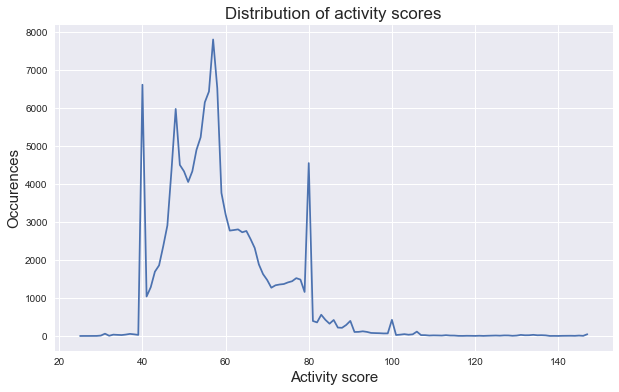

In [117]:
y_= np.empty(1)
for i in np.unique(target_reg):
    y_ = np.append(y_, len(target[target_reg == float(i)]))
y_= y_[1:]
plt.figure(figsize=(10,6))
plt.plot(np.unique(target_reg), y_)
plt.xlabel('Activity score', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of activity scores', fontsize=17)
plt.show()

We observe 3 peaks of molecular activity: 40, 60, 80. We make the following assumptions (according to the article):

> the peak at 40 can be seen as a measure representing the "inactivity";

> the peak at 80 can be seen as a measure representing the "activity";

> there are variations around these values, with a limit at 60. This limit is highly questionable. However, this is the threshold used in the article, but we could imagine testing other limits.

### Justification of the molecular activity limit at 60: maximum limit such that every molecule is active at least on one cancer cell line.

In [119]:
print('All molecule active at least on one cancer cell line with molecular activity limit at 60: %s.' %(np.sum(target_reg>=60, axis=1)>=1).all())

All molecule active at least on one cancer cell line with molecular activity limit at 60: True.


# 2. Markov Network

The first step is to construct from the target data (cell-lines bioactivity) a correlation matrix between the pairs of cell lines. Then, we can extract the Markov network from the matrix by favoring high-valued pairs (two methods will be explained afterwards).

### 2.1 - Correlation matrix

In [120]:
cor = np.corrcoef(np.transpose(target_reg)) # covariance matrix

In [121]:
' we make use of a threshold of 0.9 to build the Markov network (first method) '
thres = .9
affinity_matrix = cor.copy()
affinity_matrix[np.abs(cor) < thres] = 0
print('Number of edges: %d out of %d.' %(np.sum(affinity_matrix!=0)/2, cor.size/2))

Number of edges: 191 out of 1740.


##### Network representation

/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hol

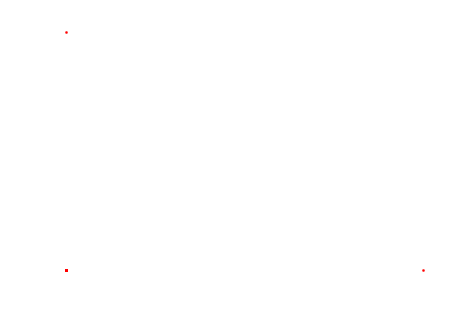

In [122]:
import networkx as nx

G_correl_matrix = nx.from_numpy_matrix(affinity_matrix) # total graph
nx.draw_spectral(G_correl_matrix, node_size=5)

We remark here that it seems that there are only three cancers in the dataset; on the contrary, the thresholding-based graph-building method created here three isolated subgraphs, with no interaction between one cancer from a subgraph and from another.

In [123]:
len(G_correl_matrix.edges())

221

### 2.2 Maximum weight spanning tree

In the paper, the maximum spanning tree is computed from additional external data. We used data from Juho Rousu's github page.

In [124]:
' Import the data '
cancerCL_corr = np.loadtxt('data/data_clean/ncicancer_cancerCL_corr.txt')

/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hol

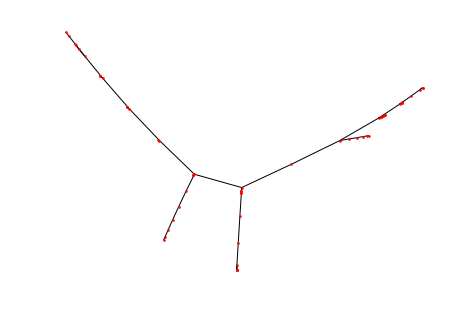

In [126]:
import networkx as nx
from spanning_tree import maximum_spanning_tree # script spanning_tree.py

G_max_spanning_tree = nx.from_numpy_matrix(cancerCL_corr) # total graph
G_max_spanning_tree = maximum_spanning_tree(G_max_spanning_tree) # graph mst (minimum spanning tree)
nx.draw_spectral(G_max_spanning_tree, node_size=5)

In [13]:
len(G_max_spanning_tree.edges())

58

##### Analysis of the graphs

In [128]:
def analyze_graph(G):

    d = list(nx.connected_component_subgraphs(G))
    n_nodes_in_subgraphs = [len(g.nodes()) for g in d]
    n_disconnected_nodes = np.sum(np.array(n_nodes_in_subgraphs)==1)
    
    print('Results:\n-------------------------------------------------------------------')
    if n_disconnected_nodes==0:
        print('All %d nodes are connected.' %(len(G.nodes())))
    else:
        print('%d disconnected subgraphs' %len(d))
        print('Minimum number of nodes in a subgraph: %d' %np.min(n_nodes_in_subgraphs))
        print('Maximum number of nodes in a subgraph: %d' %np.max(n_nodes_in_subgraphs))
        print('%d nodes (ouf of %d, i.e. %.2f%%) are singletons (i.e. disconnected from the graph)' %(n_disconnected_nodes, len(G.nodes()), n_disconnected_nodes/len(G.nodes())))

In [129]:
# Threshold
analyze_graph(G_correl_matrix)

Results:
-------------------------------------------------------------------
25 disconnected subgraphs
Minimum number of nodes in a subgraph: 1
Maximum number of nodes in a subgraph: 35
24 nodes (ouf of 59, i.e. 0.41%) are singletons (i.e. disconnected from the graph)


In [130]:
# Maximum weight spanning tree
analyze_graph(G_max_spanning_tree)

Results:
-------------------------------------------------------------------
All 59 nodes are connected.


##### Comment:

The maximum spanning tree method seems more adequate as all nodes of the *cancer cell lines* graph are connected, which is not the case when thresholding correlation.

# 3. MMCRF

## 3.1 Theoretical problem

See paper **Efficient Algorithms for Max-Margin Structured Classification, Juho Rousu et al.**

Explains very well the optimization problem to be resolved in section 1.2.6 **Marginal dual problem**:

$$ \max_{\mu}\mu^{T} l_{H} − \frac{1}{2}\mu^{T}K_{H}\mu $$

Then the gradient becomes: 

$$ g = l_{H} − K_{H}\mu $$

Furthermore, the objective can be written as :  
$$obj = \mu^{T} l_{H} − \frac{1}{2}\mu^{T}K_{H}\mu$$
$$obj = \sum_{i=1}^{m}\sum_{e\in E}\sum_{u\in Y_{E}} \mu(e,u) l_{H}(i,u) − \frac{1}{2}\sum_{e\in E}\sum_{i,i^{'}}\sum_{u,u^{'}} \mu_{e}(i,u)K_{e}(i,u;i^{'},u^{'})\mu_{e}(i^{'},u^{'})$$

That's why we need to construct the full loss vector (for each of the 4 possible labels), and $K_{mu_X}$ and $K_mu$ for the gradient descent.


In [131]:
def invert(X):
    return [not x for x in X]

class model_MMCRF:
    
    """
    Implementation of the MMCRF model, which makes use of the structure of the output and of the input to obtain
    better performances on structured learning tasks.
    
    Python adaptation of the Matlab implementation of Rousu et al. in their article (cited above).
    """
    
    def __init__(self,params):
        """
        Initialization of hyperparameters (there is a class for them)
        """
        self.params = params
        

    def profile_init(self):
        """
        Initialization of the profile --> useful to monitor the learning phase
        """
        self.start_time = time.time()
        self.next_profile_tm = self.start_time
        self.n_err = 0
        self.p_err = 0
        self.n_err_microlbl = 0
        self.p_err_microlbl = 0 
        self.n_err_microlbl_prev = 0
        self.microlabel_errors = []
        self.it = 0
        self.err_ts = 0
        self.metrics_tr = []
        print('alg: M3LBP\ttm:\titer:\tobj:\tmu:max\tmu:min\tdgap:\ttrain\tacc:\tstd:\tf1:')

    def profile_update(self):
        """
        Update of the profile
        """
        tm = time.time()
        ' We compute the current training loss '    
        m_tr, s_tr, f1_tr = self.assess_performance(self.Kx_tr, self.Y_tr)
        print('\t\t%d\t%d\t%.1e\t%.1e\t%.1e\t%.1e\t\t%.2f%%\t%.2f%%\t%.3f'
            %(np.round(tm-self.start_time), self.it, self.obj, np.max(self.mu), np.min(self.mu), self.primal_ub-self.obj, m_tr*100, s_tr*100, f1_tr))
        self.metrics_tr.append([self.it, m_tr, s_tr, f1_tr])
        
        
    def var_init(self):
        self.MBProp = np.zeros((2*self.e, 2*self.e)) # for edge to edge propagation
        self.MBPropEdgeNode = np.zeros((2*self.e, self.l)) # for edge to node propagation
        self.Rmu = []
        self.Smu = []
        self.term12 = np.zeros((1, self.e))
        self.term34 = np.zeros((4, self.e))
        
    
    def learn(self, Kx_tr, Y_tr, G):
        """
        Input data assumed by the algorithm

        Kx_tr        X-kernel, assume to be positive semidefinite and normalized (Kx_tr(i,i) = 1)
        Y_tr         Y-data: assumed to be class labels encoded {-1,+1}
        G            graph of the Markov network e_i = [E(i,1),E(i,2)]

        params       parameters used by the learning algorithm

        loss         losses associated with different edge labelings
        mu           marginal dual variables: these are the parameters to be learned

        m            number of training instances
        l            number of labels
        Ye           Denotes the edge-labelings 1 <-- [-1,-1], 2 <-- [-1,+1], 3 <-- [+1,-1], 4 <-- [+1,+1]
        IndEdgeVal   IndEdgeVal{u} = [Ye == u] 
        Kmu          Kx_tr*mu

        primal_ub
        profile
        obj
        params
        opt_round
        """

        """
        E            edges of the Markov network e_i = [E(i,1),E(i,2)]
        """
        
        self.Kx_tr = Kx_tr
        self.Y_tr = Y_tr
        self.G = G
        self.E = self.G.edges() 
        self.e = len(self.E)

        self.l = self.Y_tr.shape[1]
        self.m = self.Kx_tr.shape[0]
        self.mu = np.zeros((4*self.e,self.m))
        
        self.var_init()
        self.profile_init()
        
        self.compute_loss_vector(self.Y_tr) # automatic scaling

        ' Matrices for speeding up gradient computations '
        self.Ye = np.resize(self.loss == 0, (4,self.e*self.m))

        self.IndEdgeVal = []
        for u in range(4):
            self.IndEdgeVal.append(np.resize(self.Ye[u,:]!=0, (self.e,self.m)))

        ' Initialization of variables '

        self.Ye = np.resize(self.Ye, (4*self.e,self.m))
        self.Kxx_mu_x = np.zeros((4*self.e,self.m))
        self.Kmu = np.zeros((4*self.e*self.m,1))
        
        ' Starting descent... '
        self.obj = 0; self.primal_ub = float('inf'); self.it = 0; self.opt_round = 1;
        self.profile_update()
        self.prev_obj = 0

        ' Repeat until working set converged and close to optima '
        while (self.primal_ub - self.obj > self.params.epsilon*self.obj):

            self.progress_made = 0
            ' Conditional gradient optimization... '
            for x in range(self.m):
                ' obtain initial gradient for x : Kmu_x '
                self.Kmu_x = self.compute_Kmu_x(x, self.Kx_tr[:,x])

                ' conditional gradient optimization on x '
                x_iter = self.optimize_x(x)

                self.it += x_iter

                if self.params.verbosity==2:
                    self.profile_update()


            ' Current full gradient... '
            self.Kmu = self.compute_Kmu(self.Kx_tr, self.mu)

            self.progress_made = (self.obj > self.prev_obj)
            if self.progress_made:
                self.prev_obj = self.obj.copy()
                self.prev_mu = self.mu.copy()
            else: # restore previous solution and finish
                self.mu = self.prev_mu.copy()
                self.Kmu = self.compute_Kmu(self.Kx_tr, self.Smu, self.Rmu, self.mu)

                self.obj = self.mu.flatten().T.dot(self.loss.flatten()) - self.mu.flatten().T.dot(self.Kmu.flatten())/2 

            ' Duality gap and primal upper bound '
            self.compute_duality_gap()

            self.profile_update()

            self.opt_round = self.opt_round + 1;
            if np.logical_or(self.opt_round > self.params.max_iter, self.progress_made == 0):
                self.next_profile_tm = 0
                self.profile_update()
                break
                
        print('Descent done.')
        
    
    def compute_loss_vector(self, Y):
        """
        LOSS VECTOR
        Compute loss vector to be used in the conditional gradient optimization
        """

        labels = [-1,1]

        """Initialize loss of size (4, M*E):
            M: nb of melecules
            E: nb of edges to be predicted for each molecule
            4: nb of losses to be computed (for each of the four possible labeling we compute a different loss)"""
        self.loss = np.ones((4,self.m*self.e))

        self.E_tail = [elt[0] for elt in self.E]
        self.E_head = [elt[1] for elt in self.E]
        self.Te1 = Y[:,self.E_tail] # the label of edge tail
        self.Te2 = Y[:,self.E_head] # the label of edge head

        """Scaling the loss : rescale to microlabels by dividing node loss among the adjacent edges"""
        NodeDegree = np.ones((Y.shape[1],1))
        for v in range(self.Y_tr.shape[1]):
            NodeDegree[v] = np.sum(np.array(self.E).flatten()==v)

        NodeDegree = np.hstack(np.repeat(np.expand_dims(NodeDegree, axis = 0), self.m, axis=0)).T

        u = 0
        for u_1 in labels:
            for u_2 in labels:
                self.loss[u,:] = np.resize(np.divide((self.Te1 != u_1), NodeDegree[:, self.E_tail]) + np.divide((self.Te2 != u_2), NodeDegree[:, self.E_head]), (self.e*self.m,1))[:,0]
                u += 1
        self.loss = np.resize(self.loss, (4*self.e,self.m))

    
    def compute_duality_gap(self):
        """
        DUALITY GAP
        """

        self.loss = np.resize(self.loss, (4,self.e*self.m))
        self.Kmu = np.resize(self.Kmu, (4,self.e*self.m))
        self.mu = np.resize(self.mu, (4,self.e*self.m))

        gradient = self.loss - self.Kmu

        self.dgap = float('inf'); LBP_iter = 1; Gmax = -float('inf')

        while LBP_iter <= self.e:

            LBP_iter *= 2 # no of iterations = diameter of the graph
            
            Ymax, max_gradient = self.max_gradient_labeling(gradient, self.params) # "max_gradient" not to confuse with G
            ' "max_gradient" of size (4*e,m) '
            Gmax = np.maximum(Gmax, max_gradient)
            ' C: SVM hyperparameter '
            duality_gap = self.params.C*np.maximum(Gmax,0) - np.sum(np.resize(np.sum(gradient*self.mu.reshape(gradient.shape), 0), (self.e,self.m)), 0)
            self.dgap = np.sum(duality_gap)

            if self.obj+self.dgap < self.primal_ub+1e-6:
                break

        if self.primal_ub == float('inf'): # initial value
             self.primal_ub = self.obj+self.dgap;
        else:
             self.primal_ub = (self.obj+self.dgap)/min(self.opt_round,10) + self.primal_ub*(1-1/min(self.opt_round,10)); # averaging over a few last rounds

        self.loss = np.resize(self.loss, (4*self.e,self.m))
        self.Kmu = np.resize(self.Kmu, (4*self.e,self.m))
        self.mu = np.resize(self.mu, (4*self.e,self.m))

    
    def Y2U(self, E, Y_tr):
        """
        CONVERT NODE LABELING TO EDGE LABELING
        """
        
        m = Y_tr.shape[0]
        e = len(E)

        U = np.zeros((4,e*m))
        
        E_tail = [elt[0] for elt in E]
        E_head = [elt[1] for elt in E]
        
        Te1 = Y_tr[:,E_tail] # the label of edge tail
        Te2 = Y_tr[:,E_head] # the label of edge head

        U[0,:] = np.resize(np.logical_and(Te1 == -1, Te2 == -1), (1,e*m))
        U[1,:] = np.resize(np.logical_and(Te1 == -1, Te2 == -1), (1,e*m))
        U[2,:] = np.resize(np.logical_and(Te1 == 1, Te2 == 1), (1,e*m))
        U[3,:] = np.resize(np.logical_and(Te1 == 1, Te2 == 1), (1,e*m))

        return U
    
    
    def max_gradient_labeling_brute_force(self, Y_tr, gradient):
        """
        Brute force inference of max. gradient labeling
        """
        
        m = int(gradient.size/(4*self.e))
        
        Yall = np.zeros((2.**l,self.l))

        for j in range(l):
            tmp = np.concatenate((-np.ones((2**j,1)),np.ones((2**j,1))))
            Yall[:,j] = np.concatenate(np.repeat(np.expand_dims(tmp, 0), 2**(l-(j+1)), 0))[:,0]

        Yall = np.fliplr(Yall)

        Uall = np.resize(self.Y2U(self.E, Yall), (4*self.e,2**l))
        gradient = np.resize(gradient, (4*self.e,m))

        tmp = gradient.T.dot(Uall)

        Gmax = np.amax(tmp, 0)
        Imax = np.argmax(tmp, 0)
        Ymax = Yall[Imax,:]

        return Ymax, Gmax
    
    
    def max_gradient_labeling(self, gradient, params):
        """
        MAX GRAD. LABELING VIA LOOPY BELIEF PROPAGATION
        Find maximum gradient labeling for a single example using Loopy Belief Propagation

        gradient is of size (4*e,m) and contains the gradient (m-vector) for each edge-labeling (4*e in total)
        MBProp (2*e,2*e) direction-specific adjacency matrix
        """
        
        m = int(gradient.size/(4*self.e))

        if params.debugging==1:
            Ymax, Gmax = self.max_gradient_labeling_brute_force(gradient)
            
        else:
            
            ineg = 1; ipos = 2;

            if np.all(self.MBProp==np.zeros((2*self.e, 2*self.e))): # MBProp is set to its initial values
                self.MBProp, self.MBPropEdgeNode = self.buildBeliefPropagationMatrix(self.l)

            gradient = np.resize(gradient, (4,self.e*m))

            ' Edge-labeling specific gradient matrices (m,e) '
            Gnn = np.resize(gradient[0,:], (self.e,m)).T # edge-gradients for labeling [-1,-1]
            Gnp = np.resize(gradient[1,:], (self.e,m)).T # edge-gradients for labeling [-1,+1]
            Gpn = np.resize(gradient[2,:], (self.e,m)).T # edge-gradients for labeling [+1,-1]
            Gpp = np.resize(gradient[3,:], (self.e,m)).T # edge-gradients for labeling [+1,+1]

            ' SumMsg_*_*: mx|E| matrices storing the sums of neighboring messages from '
            ' the head and tail of the edge, respectively, on the condition that '
            ' the head (resp. tail) is labeled with -1 --> neg or +1 --> pos. '
            SumMsg_head_neg = np.zeros((m,self.e))
            SumMsg_head_pos = np.zeros((m,self.e))
            SumMsg_tail_neg = np.zeros((m,self.e))
            SumMsg_tail_pos = np.zeros((m,self.e))

            iTail = np.arange(self.e)
            iHead = np.arange(self.e,2*self.e)

            ' Iterate until messages have had time to go accros the whole graph: at '
            ' most this takes O(e) iterations (i.e. when the graph is a chain) '
            for it in range(params.max_iter):
                ' find max-gradient configuration and propage gradient value over the edge '
                Msg_head_neg = np.maximum(SumMsg_tail_pos+Gpn, SumMsg_tail_neg+Gnn)
                Msg_head_pos = np.maximum(SumMsg_tail_pos+Gpp, SumMsg_tail_neg+Gnp)
                Msg_tail_neg = np.maximum(SumMsg_head_pos+Gnp, SumMsg_head_neg+Gnn)
                Msg_tail_pos = np.maximum(SumMsg_head_pos+Gpp, SumMsg_head_neg+Gpn)

                ' Sum up gradients of consistent configurations and propage to neighboring edges '
                SumMsg_tail_neg = np.hstack((Msg_tail_neg, Msg_head_neg)).dot(self.MBProp[:,iTail])
                SumMsg_tail_pos = np.hstack((Msg_tail_pos, Msg_head_pos)).dot(self.MBProp[:,iTail])
                SumMsg_head_neg = np.hstack((Msg_tail_neg, Msg_head_neg)).dot(self.MBProp[:,iHead])
                SumMsg_head_pos = np.hstack((Msg_tail_pos, Msg_head_pos)).dot(self.MBProp[:,iHead])


            ' find out the labeling: sum up the edge messages coming towards each node '
            M_max1 = np.hstack((Msg_tail_neg, Msg_head_neg)).dot(self.MBPropEdgeNode)
            M_max2 = np.hstack((Msg_tail_pos, Msg_head_pos)).dot(self.MBPropEdgeNode)
            ' pick the label of maximum message value '
            Ymax = (M_max1 <= M_max2)*2 - 1

            ' find out the max gradient for each example: pick out the edge labelings consistent with Ymax '        
            E_tail = [elt[0] for elt in self.E]
            E_head = [elt[1] for elt in self.E]
            
            Te1 = Ymax[:,E_tail] # the label of edge tail
            Te2 = Ymax[:,E_head]

            Umax = np.zeros((4, self.e*m))

            Umax[0,:] = np.resize(np.logical_and(Te1 == -1, Te2 == -1).T, (1,self.e*m))
            Umax[1,:] = np.resize(np.logical_and(Te1 == -1, Te2 == 1).T, (1,self.e*m))
            Umax[2,:] = np.resize(np.logical_and(Te1 == 1, Te2 == -1).T, (1,self.e*m))
            Umax[3,:] = np.resize(np.logical_and(Te1 == 1, Te2 == 1).T, (1,self.e*m))
            ' sum up the corresponding edge-gradients '
            Gmax = np.resize(np.sum(gradient*Umax, 0), (self.e,m))
            Gmax = np.resize(np.sum(Gmax, 0), (m,1))

            gradient = np.resize(gradient, (4*self.e,m))

        return Ymax, Gmax
    
    
    def buildBeliefPropagationMatrix(self, n_nodes):
        """
        Construct a matrix containing the neighborhood information of the edges.
        The matrix consists of four blocks, corresponding to the edges that merge 
        (e(2) = e'(2)), branch (e(1) = e'(1)), form a chain forward (e(2) = e'(1)) or backward (e(1) = e'(2))
        """
    
        E_tail = [elt[0] for elt in self.E]
        E_head = [elt[1] for elt in self.E]

        MBProp = np.zeros((2*self.e, 2*self.e)) # for edge to edge propagation
        MBPropEdgeNode = np.zeros((2*self.e, n_nodes)) # for edge to node propagation

        iTail = np.arange(self.e)
        iHead = np.arange(self.e,2*self.e)

        for node in range(n_nodes):
            eTail = np.where(np.asarray(E_tail) == node)[0]
            eHead = np.where(np.asarray(E_head) == node)[0]

            ' Edges that meet node with their tail '
            MBPropEdgeNode[iTail[eTail], node] = 1;
            ' Edges that meet node with the head '
            MBPropEdgeNode[iHead[eHead], node] = 1;

            ' Matrix block for progating messages from edges that meet with their tails at node (eTail) '
            Link = MBProp[np.ix_(iTail,iTail)]
            Link[np.ix_(eTail,eTail)] = 1
            ' remove diagonal; we do not propage messages back to self '
            MBProp[np.ix_(iTail, iTail)] = Link - np.diag(np.diag(Link)) # check

            ' Matrix block for progating messages via a backward chain (eTail meeting eHead) at node '
            ' messages will go from iTail to iTail (excluding self loops) '
            Link = MBProp[np.ix_(iTail, iHead)]
            Link[np.ix_(eTail, eHead)] = 1
            ' remove diagonal; in case there are self loops e = (v,v) in the graph '
            MBProp[np.ix_(iTail, iHead)] = Link - np.diag(np.diag(Link))

            ' Matrix block for progating messages from edges that meet with their heads at node (eHead) '
            Link = MBProp[np.ix_(iHead, iHead)]
            Link[np.ix_(eHead, eHead)] = 1 
            ' remove diagonal; we do not propage messages back to self '
            MBProp[np.ix_(iHead, iHead)] = Link - np.diag(np.diag(Link))

            ' Matrix block for progating messages  via a forward chain (eHead meeting eTail) at node; '
            Link = MBProp[np.ix_(iHead, iTail)]
            Link[np.ix_(eHead, eTail)] = 1
            ' remove diagonal; in case there are self loops e = (v,v) in the graph '
            MBProp[np.ix_(iHead, iTail)] = Link - np.diag(np.diag(Link))

        return MBProp, MBPropEdgeNode
    
    
    def optimize_x(self, x):
        """
        Conditional gradient optimizer for a single example
        """
        
        it = 0
        while it < self.params.max_iter:
            gradient = self.loss[:,x] - self.Kmu_x[:,0]
            if np.linalg.norm(gradient) < self.params.tolerance:
                break

            ' find maximum gradient labeling (worst margin violator) '
            Ymax, Gmax = self.max_gradient_labeling(gradient, self.params)

            ' gradient towards zero '
            G0 = -self.mu[:,x].T.dot(gradient)

            ' convert to update direction '
            Umax_e = 2*(Ymax[:,self.E_tail]>0) + (Ymax[:,self.E_head]>0)

            mu_1 = np.zeros(self.mu[:,x].shape)
            if np.all(Gmax > np.maximum(self.params.tolerance, G0)):
                for u in range(4):
                    mu_1[4*(np.arange(1,self.e+1))-4 + u] = self.params.C*(Umax_e == u)

                if np.sum(mu_1) > 0:
                    smu_1_te = np.sum(np.resize(mu_1*self.Ye[:,x], (4,self.e)), 0)
                    tmp = np.repeat(np.expand_dims(smu_1_te, 0), 4, 0)
                    smu_1_te = np.resize(tmp, (self.mu[:,x].shape[0],1))
                    kxx_mu_1 = np.asarray(invert(self.Ye[:,x]))*self.params.C + mu_1 - smu_1_te[:,0]
                    
                else:
                    kxx_mu_1 = np.zeros(self.mu[:,x].shape)

                Kmu_1 = self.Kmu_x[:,0] + kxx_mu_1 - self.Kxx_mu_x[:,x];

            else:
                if G0 < self.params.tolerance:
                    break
                else:
                    kxx_mu_1 = np.zeros(self.mu[:,x].shape)
                    mu_1 = np.zeros(self.mu[:,x].shape)
                    Kmu_1 = self.Kmu_x[:,0] + kxx_mu_1 - self.Kxx_mu_x[:,x]

            d_x = mu_1 - self.mu[:,x]

            Kd_x = Kmu_1 - self.Kmu_x[:,0]
            l = gradient.T.dot(d_x)
            q = d_x.T.dot(Kd_x)
            alpha = min(l/q,1)

            delta_obj = gradient.T.dot(d_x)*alpha - alpha**2/2*d_x.T.dot(Kd_x)

            if np.logical_or(delta_obj <= 0, alpha <= 0):
                break

            self.mu[:,x] = self.mu[:,x] + d_x*alpha
            self.Kmu_x[:,0] = self.Kmu_x[:,0] + Kd_x*alpha
            self.obj = self.obj + delta_obj
            self.Kxx_mu_x[:,x] = (1-alpha)*self.Kxx_mu_x[:,x] + alpha*kxx_mu_1

            it += 1

        """
        For speeding up gradient computations: 
        store sums of marginal dual variables, distributed by the true edge values into Smu
        store marginal dual variables, distributed by the pseudo edge values into Rmu
        """
        
        temp = self.mu[:,x].reshape((4,self.e))

        for u in range(4):
            self.Smu[u][:,x] = np.sum(temp).T*self.IndEdgeVal[u][:,x]
            self.Rmu[u][:,x] = temp[u,:].T

        self.mu[:,x] = np.resize(temp, (4*self.e,1))[:,0]
        
        return it
    

    def compute_Kmu_x(self, x, Kx):
        """
        GRADIENT COMPUTATIONS
        Gradient for x
        """

        """
        For speeding up gradient computations:
        Smu : store sums of marginal dual variables, distributed by the true edge values
        Rmu : store marginal dual variables, distributed by the pseudo edge values
        """
        
        m = Kx.shape[0]

        if self.Rmu == []:
            for u in range(4):
                self.Smu.append(np.zeros((self.e,m)))
                self.Rmu.append(np.zeros((self.e,m)))

        for u in range(4):
            Ind_te_u = self.IndEdgeVal[u][:,x] # loss of edges for this label, associated to the moledule x (boolean)
            H_u = self.Smu[u].dot(Kx)- self.Rmu[u].dot(Kx)
            
            self.term12[0,Ind_te_u] = H_u[Ind_te_u].T
            self.term34[u,:] = - H_u.T

        tmp = np.vstack(np.repeat(np.expand_dims(self.term12,axis=0), 4, axis=0))

        Kmu_x = np.resize(tmp + self.term34, (4*self.e,1))
        
        return Kmu_x
    
    
    def compute_Kmu(self, Kx, mu0):
        """
        Complete gradient
        """

        m, m_oup = Kx.shape

        if 0:
            for x in range(m):
                self.Kmu[:,x] = self.compute_Kmu_x(x, Kx[:,x], self.E, IndEdgeVal)

            Kmu = np.resize(Kmu, (4,self.e*m))
            
        else:

            mu0 = np.resize(mu0, (4,self.e*m))
            Smu = np.resize(np.sum(mu0, 0),(self.e,m))
            term12 = np.zeros((1,self.e*m_oup))
            Kmu = np.zeros((4,self.e*m_oup))

            for u in range(4):
                IndEVu = self.IndEdgeVal[u]
                Rmu_u = np.resize(mu0[u,:], (self.e,m))
                H_u = Smu*IndEVu
                H_u = H_u - Rmu_u
                Q_u = H_u.dot(Kx)

                term12 = term12 + np.resize(Q_u*IndEVu, (1,self.e*m_oup))
                Kmu[u,:] = np.resize(-Q_u, (1,self.e*m_oup))

            for u in range(4):
                Kmu[u,:] = Kmu[u,:] + term12

        return Kmu
    
    
    def compute_w_phi_e(self, Kx):

        m = Kx.shape[0]
        self.Ye = np.resize(self.Ye, (4,self.e*m))
        self.mu = np.resize(self.mu, (4,self.e*m))
        m_oup = Kx.shape[1]

        if not np.any(self.mu>0): # no match
            self.w_phi_e = np.zeros((4, self.e*m_oup))
            
        else:
            self.w_phi_e = np.sum(self.mu, 0)
            self.w_phi_e = np.repeat(np.expand_dims(self.w_phi_e, 0), 4, 0)
            self.w_phi_e = self.Ye*self.w_phi_e
            self.w_phi_e = self.w_phi_e - self.mu
            self.w_phi_e = np.resize(self.w_phi_e, (4*self.e,m))
            self.w_phi_e = self.w_phi_e.dot(Kx)
            self.w_phi_e = np.resize(self.w_phi_e, (4,self.e*m_oup))
            
        self.Ye = np.resize(self.Ye, (4*self.e,m))
        self.mu = np.resize(self.mu, (4*self.e,m))

    
    def predict(self, Kx):
        """
        MODEL ERROR COMPUTATION
        """
        
        self.compute_w_phi_e(Kx)
        Ypred, _ = self.max_gradient_labeling(self.w_phi_e, self.params)
        
        return Ypred
    
    
    def assess_performance(self, Kx, y_true, verbose=False):
        """
        Compute the accuracy score of a kernel sample Kx
        y_true are the true labels
        """
        
        self.Ypred = self.predict(Kx)
        accuracy_per_mol = np.mean(self.Ypred == y_true, 1)
        f1 = f1_score(y_true.flatten(),self.Ypred.flatten())
        if verbose:
            print('Average accuracy: %.2f%%' %(np.mean(accuracy_per_mol)*100))
            print('Standard deviation: %.2f%%' %(np.std(accuracy_per_mol)*100))
            print('F1 score: %.2f%%' %(f1*100))
        
        return np.mean(accuracy_per_mol), np.std(accuracy_per_mol), f1
    
    def plot_results(self):
        """
        Plot the evolution of the metrics with the number of iterations
        """
        
        tmp = np.array(self.metrics_tr)
        
        list_iter = tmp[:,0]
        list_mean_acc = tmp[:,1]
        list_mean_std = tmp[:,2]
        list_f1_score = tmp[:,3]

        f, ax = plt.subplots(figsize=(12,5), dpi=60)

        ax.plot(list_iter, list_mean_acc, label='mean accuracy')
        ax.plot(list_iter, list_mean_std, label='accuracy std')
        ax.plot(list_iter, list_f1_score, label='f1 score')
        ax.set_ylim([0,1])
        ax.set_xlim([min(list_iter),max(list_iter)])
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel('iterations', fontsize=15)
        ax.set_title('Evolution of metrics with number of iterations.', fontsize=17)
        plt.show()
        

In [132]:
class params():
    
    """
    Parameters for the MMCRF model.
    """
    
    def __init__(self, C, epsilon, tolerance, max_iter, max_CGD_iter, max_LBP_iter, profiling, profile_tm_interval, verbosity, debugging):
        self.C = C
        self.epsilon = epsilon
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.max_CGD_iter = max_CGD_iter
        self.max_LBP_iter = max_LBP_iter
        self.profiling = profiling
        self.profile_tm_interval = profile_tm_interval
        self.verbosity = verbosity
        self.debugging = debugging

In [133]:
import time

class profile():
    """
    EXECUTION PROFILING
    """
    
    def __init__(self):
        self.start_time = time.time()
        self.next_profile_tm = self.start_time
        self.n_err = 0
        self.p_err = 0
        self.n_err_microlbl = 0
        self.p_err_microlbl = 0 
        self.n_err_microlbl_prev = 0
        self.microlabel_errors = []
        self.it = 0
        self.err_ts = 0
        print('alg: M3LBP\ttm:\titer:\tobj:\tmu:max\tmu:min\tdgap:')
        
    def profile_update(self, Ye, obj, mu, primal_ub, params):
        
        m = Ye.shape[1]
        tm = time.time()

        print('\t\t%d\t%d\t%.2f\t%.2f\t%.2f\t%.2f'
        %(np.round(tm-self.start_time), self.it, obj, np.max(mu), np.min(mu), primal_ub-obj))


In [134]:
parameters = params(C = 100,
                    epsilon = 1,
                    tolerance = 1e-8,
                    max_iter = 10,
                    max_CGD_iter = 100,
                    max_LBP_iter = 10,
                    profiling = True,
                    profile_tm_interval = True,
                    verbosity = 1,
                    debugging = False)

## Test

We train the algorithm on a sample of 10 molecules against all 59 cancer cell lines and test it on 90 molecules.

In [135]:
y_label = target.copy()
Kx_tr = Kx[2000:2010,2000:2010]; y_label_tr = y_label[2000:2010,:]
Kx_ts = Kx[2000:2010,2010:2100]; y_label_ts = y_label[2010:2100,:]

In [136]:
"""
We check that no cancer has zero molecules with effects or the contrary
"""
if np.any(np.all(y_label_tr==1, 0)):
    print(np.where(np.all(y_label_tr==1, 1)))
    if np.any(np.all(y_label_tr==-1, 0)):
        print(np.where(np.all(y_label_tr==-1, 1)))
else:
    print('All good!')

All good!


### We test the model for:

- The output graph obtained by applying a maximum spanning tree algorithm 

- The output graph obtained by correlation thresholding

#### Maximum spanning tree

In [137]:
model = model_MMCRF(parameters)
model.learn(Kx_tr, y_label_tr, G_max_spanning_tree)

alg: M3LBP	tm:	iter:	obj:	mu:max	mu:min	dgap:	train	acc:	std:	f1:
		0	0	0.0e+00	0.0e+00	0.0e+00	inf		8.47%	0.00%	0.156
		0	2	4.8e+00	4.0e-01	0.0e+00	5.1e+05		66.44%	3.20%	0.100
		0	5	4.1e+02	4.2e-01	0.0e+00	5.1e+05		64.07%	3.54%	0.078
		0	8	8.6e+02	3.8e-01	0.0e+00	5.1e+05		64.41%	3.71%	0.087
		0	10	1.2e+03	3.7e-01	0.0e+00	5.1e+05		67.46%	3.46%	0.150
		0	13	1.6e+03	4.3e-01	0.0e+00	5.1e+05		69.83%	3.20%	0.110
		0	24	2.1e+03	4.4e-01	0.0e+00	5.1e+05		68.47%	3.41%	0.155
		0	35	2.6e+03	4.2e-01	0.0e+00	5.1e+05		66.10%	3.39%	0.091
		0	37	3.0e+03	3.8e-01	0.0e+00	5.1e+05		60.00%	3.95%	0.092
		0	40	3.3e+03	4.1e-01	0.0e+00	5.1e+05		66.10%	3.03%	0.091
		0	44	3.8e+03	5.3e-01	0.0e+00	5.1e+05		66.27%	3.43%	0.091
		0	44	3.8e+03	5.3e-01	0.0e+00	5.1e+05		66.27%	3.43%	0.091
Descent done.


In [140]:
# Results on training set
m_tr, s_tr, f1_tr = model.assess_performance(Kx_tr, y_label_tr, True)

Average accuracy: 66.27%
Standard deviation: 3.43%
F1 score: 9.13%


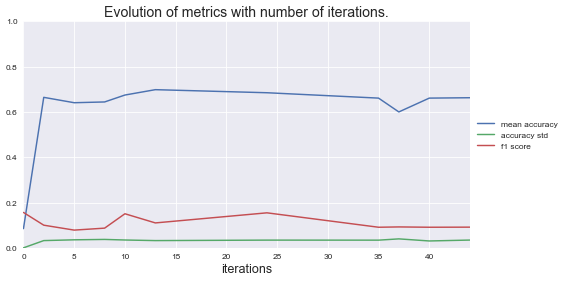

In [139]:
model.plot_results()

In [141]:
# Results on test set
m_ts, s_ts, f1_ts = model.assess_performance(Kx_ts, y_label_ts, True)

Average accuracy: 64.05%
Standard deviation: 4.87%
F1 score: 21.08%


#### Correlation thresholding

In [142]:
model = model_MMCRF(parameters)
model.learn(Kx_tr, y_label_tr, G_correl_matrix)

alg: M3LBP	tm:	iter:	obj:	mu:max	mu:min	dgap:	train	acc:	std:	f1:
		0	0	0.0e+00	0.0e+00	0.0e+00	inf		8.47%	0.00%	0.156
		0	3	1.6e+00	9.8e-02	0.0e+00	4.9e+05		82.37%	1.55%	0.055
		1	5	3.6e+02	8.5e-02	0.0e+00	5.0e+05		85.08%	2.25%	0.120
		1	16	6.2e+02	9.1e-02	0.0e+00	5.0e+05		84.58%	1.93%	0.165
		1	19	9.3e+02	8.5e-02	0.0e+00	5.0e+05		85.76%	1.55%	0.067
		2	21	1.2e+03	9.3e-02	0.0e+00	5.0e+05		84.41%	1.83%	0.164
		2	25	1.5e+03	8.8e-02	0.0e+00	5.0e+05		84.75%	2.63%	0.182
		2	28	1.8e+03	9.6e-02	0.0e+00	5.0e+05		86.44%	3.03%	0.259
		2	39	2.1e+03	8.5e-02	0.0e+00	5.0e+05		87.12%	1.55%	0.156
		3	42	2.4e+03	9.4e-02	0.0e+00	5.0e+05		87.12%	1.55%	0.156
		3	45	2.7e+03	8.7e-02	0.0e+00	5.0e+05		85.42%	1.55%	0.140
		3	45	2.7e+03	8.7e-02	0.0e+00	5.0e+05		85.42%	1.55%	0.140
Descent done.


In [143]:
# Results on training set
m_tr, s_tr, f1_tr = model.assess_performance(Kx_tr, y_label_tr, True)

Average accuracy: 85.42%
Standard deviation: 1.55%
F1 score: 14.00%


In [144]:
# Results on test set
m_ts, s_ts, f1_ts = model.assess_performance(Kx_ts, y_label_ts, True)

Average accuracy: 77.29%
Standard deviation: 5.54%
F1 score: 10.53%


#### Test of stratified k-fold to estimate the risk of the model

In [145]:
parameters = params(C = 100,
                    epsilon = 1,
                    tolerance = 1e-8, # 10e-8
                    max_iter = 5,
                    max_CGD_iter = 5, #100
                    max_LBP_iter = 5,
                    profiling = True,
                    profile_tm_interval = True,
                    verbosity = 1,
                    debugging = False)

Stratified kfold with maximum-weight spanning tree

In [146]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5)
listOfAccuracies_tr = []
listOfAccuracies_ts = []
listOfF1_tr = []
listOfF1_ts = []

#Little trick to stratify according to equivalence classes based on the number of cells against which the molecules
#are active.

listOfPercent = np.percentile(np.sum(y_label, axis = 1),list((np.arange(10))*10))
bins = np.digitize(np.sum(y_label, axis = 1), listOfPercent)

k = 1

for train, test in skf.split(Kx, bins):
    print('Fold %d\n----------------------------------------------------------------------------------------------' %k)
    """
    We run a MMCRF model for each fold
    """
    Kx_tr, y_label_tr = Kx[np.ix_(train, train)], y_label[train,:]
    Kx_ts, y_label_ts = Kx[np.ix_(train, test)], y_label[test,:]
    
    model = model_MMCRF(parameters)
    model.learn(Kx_tr, y_label_tr, G_max_spanning_tree)
    
    """
    We compute the accuracy of the model on both the train and test datasets
    """
    
    m_tr, s_tr, f1_tr = model.assess_performance(Kx_tr, y_label_tr, False)
    m_ts, s_ts, f1_ts = model.assess_performance(Kx_ts, y_label_ts, False)
    
    if k==1:
        Y_pred = model.Ypred
        Y_true = y_label[test,:]
    else:
        Y_pred = np.vstack((Y_pred, model.Ypred))
        Y_true = np.vstack((Y_true, y_label[test,:]))
    
    listOfAccuracies_tr.append(m_tr)
    listOfAccuracies_ts.append(m_ts)
    listOfF1_tr.append(f1_tr)
    listOfF1_ts.append(f1_ts)
    
    k +=1

Fold 1
----------------------------------------------------------------------------------------------
alg: M3LBP	tm:	iter:	obj:	mu:max	mu:min	dgap:	train	acc:	std:	f1:
		0	0	0.0e+00	0.0e+00	0.0e+00	inf		37.32%	38.83%	0.544
		5	12	1.3e+01	4.1e-01	0.0e+00	1.7e+10		52.26%	9.03%	0.382
		12	31	1.1e+03	4.0e-01	0.0e+00	1.7e+10		53.20%	12.07%	0.358
		18	53	1.7e+03	4.5e-01	0.0e+00	1.7e+10		55.09%	17.71%	0.309
		23	86	2.6e+03	2.3e-01	0.0e+00	1.7e+10		53.53%	14.31%	0.330
		28	124	2.8e+03	3.2e-01	0.0e+00	1.7e+10		54.45%	12.85%	0.370
		28	124	2.8e+03	3.2e-01	0.0e+00	1.7e+10		54.45%	12.85%	0.370
Descent done.
Fold 2
----------------------------------------------------------------------------------------------
alg: M3LBP	tm:	iter:	obj:	mu:max	mu:min	dgap:	train	acc:	std:	f1:
		0	0	0.0e+00	0.0e+00	0.0e+00	inf		36.63%	38.54%	0.536
		4	13	1.1e+01	4.1e-01	0.0e+00	1.7e+10		54.57%	13.14%	0.347
		8	33	8.2e+02	3.8e-01	0.0e+00	1.7e+10		54.56%	13.39%	0.349
		12	57	1.5e+03	2.1e-01	0.0e+00	1.7e+10		53.50%	15.57%

In [147]:
print('Training set:\n-------------------------')
print('Average accuracy: %.2f%%' %(np.mean(listOfAccuracies_tr)*100))
print('Average F1 score: %.2f%%' %(np.mean(listOfF1_tr)*100))
print('\nValidation set:\n-------------------------')
print('Average accuracy: %.2f%%' %(np.mean(listOfAccuracies_ts)*100))
print('Average F1 score: %.2f%%' %(np.mean(listOfF1_ts)*100))

Training set:
-------------------------
Average accuracy: 54.91%
Average F1 score: 35.43%

Validation set:
-------------------------
Average accuracy: 54.76%
Average F1 score: 35.24%


With middle Active dataset (+ maximum-weight spanning tree)

In [151]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5)
listOfAccuracies_tr = []
listOfAccuracies_ts = []
listOfF1_tr = []
listOfF1_ts = []

#Little trick to stratify according to equivalence classes based on the number of cells against which the molecules
#are active.

listOfPercent = np.percentile(np.sum(y_label_temp, axis = 1),list((np.arange(10))*10))
bins = np.digitize(np.sum(y_label_temp, axis = 1), listOfPercent)

k = 1

for train, test in skf.split(Kx_temp, bins):
    print('Fold %d\n----------------------------------------------------------------------------------------------' %k)
    """
    We run a MMCRF model for each fold
    """
    Kx_tr, y_label_tr = Kx_temp[np.ix_(train, train)], y_label_temp[train,:]
    Kx_ts, y_label_ts = Kx_temp[np.ix_(train, test)], y_label_temp[test,:]
    
    model = model_MMCRF(parameters)
    model.learn(Kx_tr, y_label_tr, G_max_spanning_tree)
    
    """
    We compute the accuracy of the model on both the train and test datasets
    """
    
    m_tr, s_tr, f1_tr = model.assess_performance(Kx_tr, y_label_tr, False)
    m_ts, s_ts, f1_ts = model.assess_performance(Kx_ts, y_label_ts, False)
    
    if k==1:
        Y_pred = model.Ypred
        Y_true = y_label_temp[test,:]
    else:
        Y_pred = np.vstack((Y_pred, model.Ypred))
        Y_true = np.vstack((Y_true, y_label_temp[test,:]))
    
    listOfAccuracies_tr.append(m_tr)
    listOfAccuracies_ts.append(m_ts)
    listOfF1_tr.append(f1_tr)
    listOfF1_ts.append(f1_ts)
    
    k +=1

Fold 1
----------------------------------------------------------------------------------------------
alg: M3LBP	tm:	iter:	obj:	mu:max	mu:min	dgap:	train	acc:	std:	f1:
		0	0	0.0e+00	0.0e+00	0.0e+00	inf		46.69%	20.19%	0.637
		1	44	7.9e+01	9.4e-01	0.0e+00	8.5e+08		48.55%	6.50%	0.441
		2	65	5.7e+03	1.8e+00	0.0e+00	8.8e+08		53.15%	6.02%	0.527
		2	97	3.1e+04	4.5e+00	0.0e+00	9.3e+08		50.25%	6.21%	0.431
		3	119	9.3e+04	7.1e+00	0.0e+00	1.0e+09		52.64%	5.93%	0.490
		4	135	2.5e+05	1.1e+00	0.0e+00	9.8e+08		48.02%	6.77%	0.433
		4	135	2.5e+05	1.1e+00	0.0e+00	9.8e+08		48.02%	6.77%	0.433
Descent done.
Fold 2
----------------------------------------------------------------------------------------------
alg: M3LBP	tm:	iter:	obj:	mu:max	mu:min	dgap:	train	acc:	std:	f1:
		0	0	0.0e+00	0.0e+00	0.0e+00	inf		46.29%	20.12%	0.633
		1	54	1.0e+02	9.7e-01	0.0e+00	8.2e+08		50.24%	7.14%	0.437
		2	88	8.2e+03	2.6e+00	0.0e+00	8.9e+08		48.41%	5.18%	0.454
		2	126	3.8e+04	5.8e-01	0.0e+00	8.7e+08		50.85%	7.39%	0.422
		3	1

In [152]:
print('Training set:\n-------------------------')
print('Average accuracy: %.2f%%' %(np.mean(listOfAccuracies_tr)*100))
print('Average F1 score: %.2f%%' %(np.mean(listOfF1_tr)*100))
print('\nValidation set:\n-------------------------')
print('Average accuracy: %.2f%%' %(np.mean(listOfAccuracies_ts)*100))
print('Average F1 score: %.2f%%' %(np.mean(listOfF1_ts)*100))

Training set:
-------------------------
Average accuracy: 51.28%
Average F1 score: 43.13%

Validation set:
-------------------------
Average accuracy: 51.51%
Average F1 score: 43.32%
